<a href="https://colab.research.google.com/github/Adrxking/colabs/blob/main/CNN_Animals_Adrian_Vitys_Vitiene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

In [2]:
# Montamos el Google Drive en el directorio del proyecto y
# descomprimios el fichero con los datos
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -n '/content/drive/MyDrive/Colab Notebooks/animals.zip' >> /dev/null

In [4]:
# Path to the data directory
data_dir = './raw-img'

# All categories
categories = ['farfalla', 'gatto', 'gallina', 'mucca', 'cane', 'elefante', 'cavallo', 'pecora', 'ragno', 'scoiattolo']

# The size to which the images will be resized
img_size = 64

# Loading the images and their labels
data = []
for category in categories:
    path = os.path.join(data_dir, category)
    class_num = categories.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (img_size, img_size))
            data.append([new_array, class_num])
        except Exception as e:
            pass

# Shuffling the data
random.shuffle(data)

# Splitting the features and labels
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

# Converting features and labels to numpy arrays
X = np.array(X).reshape(-1, img_size, img_size, 3)
y = np.array(y)

# Normalizing the data
X = X/255.0

# Converting the labels to one-hot encoding
y = to_categorical(y)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
print(len(X_train) / 32)

654.46875


In [7]:
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(len(categories)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

# Aumento de datos
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
datagen.fit(X_train)

history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    steps_per_epoch=X_train.shape[0] // 32,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop, model_checkpoint],
                    use_multiprocessing=True,
                    workers=8)

Epoch 1/50
654/654 [==============================] - ETA: 0s - loss: 1.9949 - accuracy: 0.3656
Epoch 1: val_accuracy improved from -inf to 0.35523, saving model to best_model.h5
654/654 [==============================] - 46s 49ms/step - loss: 1.9949 - accuracy: 0.3656 - val_loss: 2.0794 - val_accuracy: 0.3552
Epoch 2/50
652/654 [============================>.] - ETA: 0s - loss: 1.4041 - accuracy: 0.5255
Epoch 2: val_accuracy improved from 0.35523 to 0.56283, saving model to best_model.h5
654/654 [==============================] - 34s 50ms/step - loss: 1.4043 - accuracy: 0.5252 - val_loss: 1.2929 - val_accuracy: 0.5628
Epoch 3/50
653/654 [============================>.] - ETA: 0s - loss: 1.2363 - accuracy: 0.5797
Epoch 3: val_accuracy did not improve from 0.56283
654/654 [==============================] - 32s 47ms/step - loss: 1.2366 - accuracy: 0.5796 - val_loss: 1.4942 - val_accuracy: 0.5369
Epoch 4/50
654/654 [==============================] - ETA: 0s - loss: 1.1348 - accuracy: 0.61

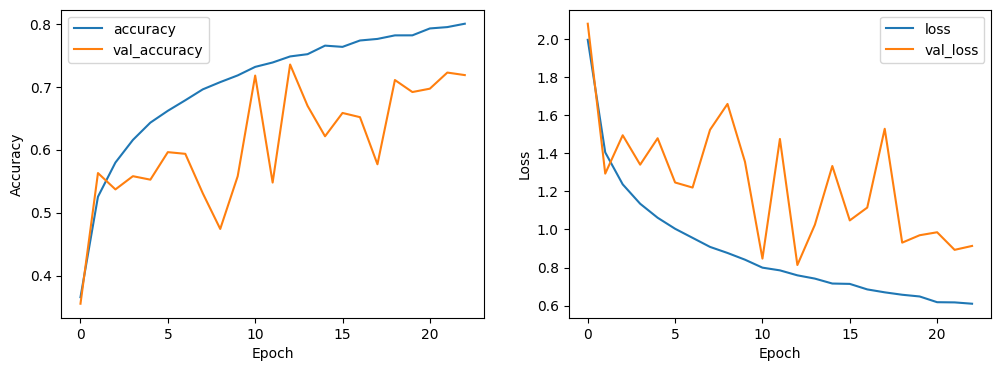

In [8]:
# Visualizing the model performance
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

164/164 [==============================] - 1s 4ms/step


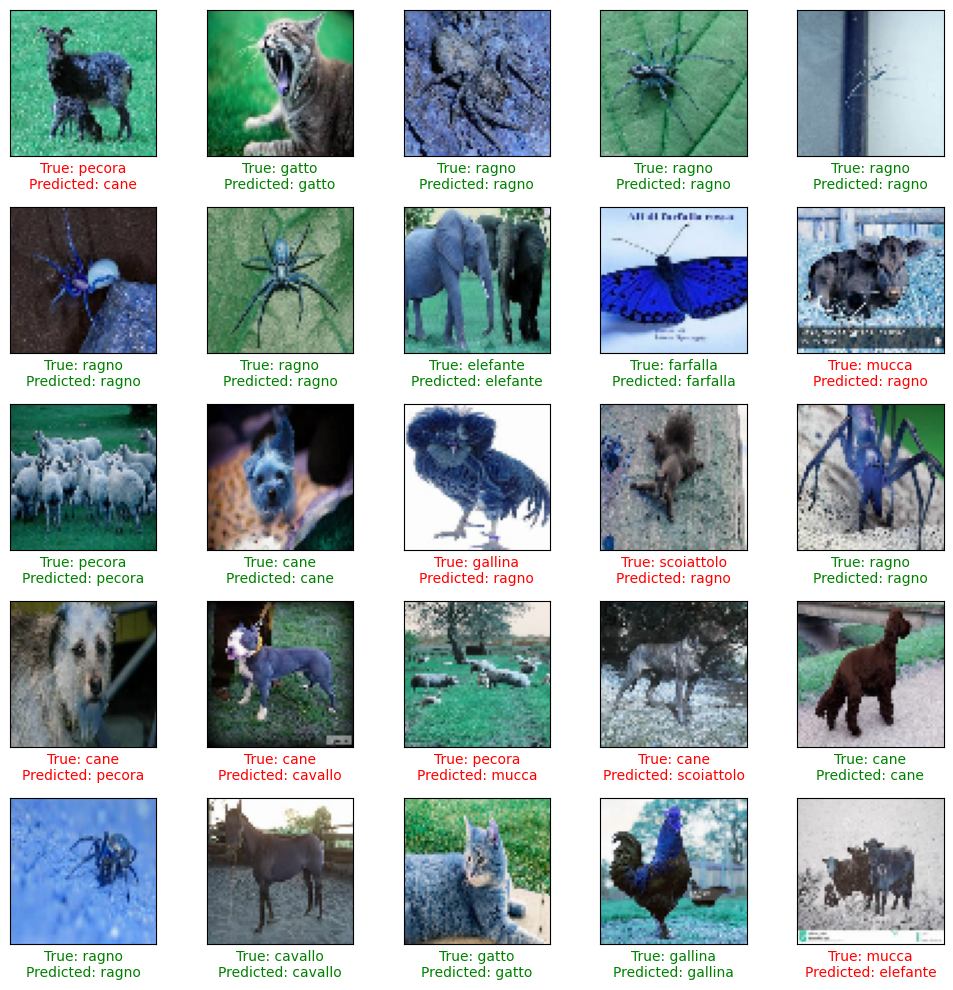

In [12]:
# Cargamos el modelo guardado
model = load_model('best_model.h5')

# Obtenemos las predicciones de las imágenes de prueba
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Mostramos algunas imágenes con sus etiquetas verdaderas y predichas
plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Mostramos la imagen
    plt.imshow(X_test[i])

    # Obtenemos la etiqueta verdadera y la predicha
    true_label = categories[np.argmax(y_test[i])]
    predicted_label = categories[predicted_classes[i]]

    # Coloreamos las etiquetas; verde para las correctas y rojo para las incorrectas
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel(f"True: {true_label}\nPredicted: {predicted_label}", color=color)

plt.tight_layout()
plt.show()
